# Power Analysis & Sample Size Calculator

This notebook provides Python-based power analysis tools as an alternative to web-based calculators for **Breakout 2**.

## Key Concepts

| Term       | Definition                                                                | Typical Value     |
| ---------- | ------------------------------------------------------------------------- | ----------------- |
| α (alpha) | Probability of false positive (Type I error)                              | 0.05 (5%)         |
| β (beta)  | Probability of false negative (Type II error)                            | 0.20 (20%)        |
| Power      | Probability of detecting true effect (1 − β)                             | 0.80 (80%)        |
| MDE        | Minimum Detectable Effect—smallest lift you can reliably detect          | Context-dependent |
| Baseline   | Current conversion/metric rate (your data)                                | Your data         |

**Tradeoff**: Smaller MDE → Larger sample size → Longer experiment.


In [ ]:
# Install required packages if not already installed
# Uncomment the line below if you need to install these packages:
# !pip install numpy scipy matplotlib pandas

# Import required libraries
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

SyntaxError: invalid syntax (3822932858.py, line 3)

In [ ]:
# All imports are in the previous cell (Cell 1)
# If you need to install packages, uncomment the pip install line in Cell 1


## Function: Calculate Sample Size for Binary Metrics

This function calculates the required sample size per variant for a binary outcome (e.g., conversion rate).


In [12]:
def calculate_sample_size_binary(baseline_rate, mde_relative, alpha=0.05, power=0.80):
    """
    Calculate sample size per variant for a binary outcome (conversion rate).
    
    Parameters:
    -----------
    baseline_rate : float
        Current conversion rate (e.g., 0.05 for 5%)
    mde_relative : float
        Minimum Detectable Effect as relative lift (e.g., 0.10 for 10% relative)
    alpha : float
        Significance level (Type I error rate), default 0.05
    power : float
        Statistical power (1 - Type II error rate), default 0.80
    
    Returns:
    --------
    n_per_variant : int
        Sample size needed per variant
    """
    # Calculate absolute MDE
    mde_absolute = baseline_rate * mde_relative
    new_rate = baseline_rate + mde_absolute
    
    # Z-scores
    z_alpha = norm.ppf(1 - alpha/2)  # Two-tailed test
    z_beta = norm.ppf(power)
    
    # Pooled standard error
    p_pooled = (baseline_rate + new_rate) / 2
    se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/baseline_rate + 1/new_rate))
    
    # Sample size formula for proportions
    n = ((z_alpha + z_beta) ** 2 * (baseline_rate * (1 - baseline_rate) + new_rate * (1 - new_rate))) / (mde_absolute ** 2)
    
    return int(np.ceil(n))

# Example: Scenario 1
baseline = 0.05  # 5%
mde = 0.10  # 10% relative
n_per_variant = calculate_sample_size_binary(baseline, mde)
print(f"Scenario 1: Sample size per variant = {n_per_variant:,}")
print(f"Total users needed (both variants) = {n_per_variant * 2:,}")


Scenario 1: Sample size per variant = 31,231
Total users needed (both variants) = 62,462


## Function: Calculate MDE Given Sample Size

Reverse calculation: Given a fixed sample size, what's the smallest effect you can detect?


In [13]:
def calculate_mde_from_sample_size(baseline_rate, n_per_variant, alpha=0.05, power=0.80):
    """
    Calculate the Minimum Detectable Effect given a fixed sample size.
    
    Parameters:
    -----------
    baseline_rate : float
        Current conversion rate
    n_per_variant : int
        Sample size per variant
    alpha : float
        Significance level, default 0.05
    power : float
        Statistical power, default 0.80
    
    Returns:
    --------
    mde_absolute : float
        Minimum detectable effect (absolute)
    mde_relative : float
        Minimum detectable effect (relative)
    """
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)
    
    # Standard error for baseline
    se = np.sqrt(baseline_rate * (1 - baseline_rate) / n_per_variant)
    
    # MDE calculation
    mde_absolute = (z_alpha + z_beta) * se * np.sqrt(2)  # sqrt(2) for two-sample test
    mde_relative = mde_absolute / baseline_rate
    
    return mde_absolute, mde_relative

# Example: Scenario 3
n = 1000  # per variant
mde_abs, mde_rel = calculate_mde_from_sample_size(baseline, n)
print(f"Scenario 3: With n={n:,} per variant:")
print(f"  MDE (absolute) = {mde_abs:.4f} ({mde_abs*100:.2f}%)")
print(f"  MDE (relative) = {mde_rel:.2%}")


Scenario 3: With n=1,000 per variant:
  MDE (absolute) = 0.0273 (2.73%)
  MDE (relative) = 54.61%


## Function: Calculate Power Given Sample Size and Effect

Given a sample size and true effect, what's your actual power?


In [14]:
def calculate_power(baseline_rate, true_effect_relative, n_per_variant, alpha=0.05):
    """
    Calculate statistical power given sample size and true effect.
    
    Parameters:
    -----------
    baseline_rate : float
        Current conversion rate
    true_effect_relative : float
        True effect as relative lift (e.g., 0.08 for 8% relative)
    n_per_variant : int
        Sample size per variant
    alpha : float
        Significance level, default 0.05
    
    Returns:
    --------
    power : float
        Statistical power (probability of detecting the effect)
    """
    true_effect_absolute = baseline_rate * true_effect_relative
    new_rate = baseline_rate + true_effect_absolute
    
    z_alpha = norm.ppf(1 - alpha/2)
    
    # Standard errors
    se_baseline = np.sqrt(baseline_rate * (1 - baseline_rate) / n_per_variant)
    se_new = np.sqrt(new_rate * (1 - new_rate) / n_per_variant)
    se_pooled = np.sqrt(se_baseline**2 + se_new**2)
    
    # Critical value
    critical_value = z_alpha * se_pooled
    
    # Z-score for true effect
    z_stat = true_effect_absolute / se_pooled
    
    # Power = probability of exceeding critical value
    power = 1 - norm.cdf(critical_value / se_pooled - z_stat)
    
    return power

# Example: Scenario 3 question
true_effect = 0.08  # 8% relative
actual_power = calculate_power(baseline, true_effect, n)
print(f"If true effect is {true_effect:.0%} relative lift:")
print(f"  Actual power with n={n:,} per variant = {actual_power:.2%}")


If true effect is 8% relative lift:
  Actual power with n=1,000 per variant = 5.97%


## Visualization: Sample Size vs. MDE

Visualize how sample size requirements change with different MDEs.


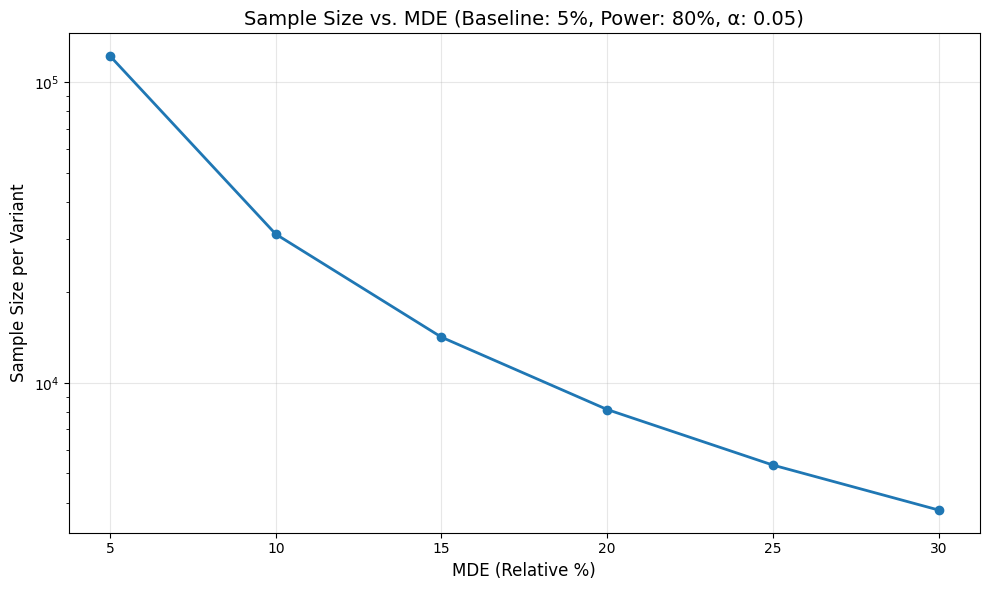

In [15]:
def plot_sample_size_vs_mde(baseline_rate, mde_range, alpha=0.05, power=0.80):
    """
    Plot sample size requirements for different MDE values.
    """
    sample_sizes = [calculate_sample_size_binary(baseline_rate, mde, alpha, power) 
                    for mde in mde_range]
    
    plt.figure(figsize=(10, 6))
    plt.plot([m*100 for m in mde_range], sample_sizes, marker='o', linewidth=2)
    plt.xlabel('MDE (Relative %)', fontsize=12)
    plt.ylabel('Sample Size per Variant', fontsize=12)
    plt.title(f'Sample Size vs. MDE (Baseline: {baseline_rate*100:.0f}%, Power: {power:.0%}, α: {alpha})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

# Example plot
mde_range = np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30])  # 5% to 30% relative
plot_sample_size_vs_mde(baseline, mde_range)


## Breakout 2 Scenarios

Use the functions above to answer the scenarios in Breakout 2.


In [16]:
# Scenario 1: The Standard Test
print("=" * 50)
print("SCENARIO 1: The Standard Test")
print("=" * 50)
baseline_1 = 0.05  # 5%
mde_1 = 0.10  # 10% relative
n1 = calculate_sample_size_binary(baseline_1, mde_1)
print(f"Baseline: {baseline_1*100:.0f}%")
print(f"MDE: {mde_1:.0%} relative ({baseline_1*mde_1*100:.2f}% absolute)")
print(f"Sample size per variant: {n1:,}")
print(f"Total users needed: {n1 * 2:,}")
print(f"\nIf you have 1,000 users/week, you need {np.ceil(n1 * 2 / 1000):.0f} weeks")

print("\n" + "=" * 50)
print("SCENARIO 2: The Shrinking MDE")
print("=" * 50)
mde_2 = 0.05  # 5% relative
n2 = calculate_sample_size_binary(baseline_1, mde_2)
print(f"Baseline: {baseline_1*100:.0f}%")
print(f"MDE: {mde_2:.0%} relative ({baseline_1*mde_2*100:.2f}% absolute)")
print(f"Sample size per variant: {n2:,}")
print(f"Total users needed: {n2 * 2:,}")
print(f"\nSample size is {n2/n1:.1f}x larger than Scenario 1")

print("\n" + "=" * 50)
print("SCENARIO 3: The Power Play")
print("=" * 50)
n3 = 1000  # per variant
mde_abs_3, mde_rel_3 = calculate_mde_from_sample_size(baseline_1, n3)
print(f"With n={n3:,} per variant (2,000 total):")
print(f"Smallest detectable effect: {mde_rel_3:.1%} relative")

true_effect_3 = 0.08  # 8% relative
power_3 = calculate_power(baseline_1, true_effect_3, n3)
print(f"\nIf true effect is {true_effect_3:.0%} relative:")
print(f"Actual power: {power_3:.1%}")


SCENARIO 1: The Standard Test
Baseline: 5%
MDE: 10% relative (0.50% absolute)
Sample size per variant: 31,231
Total users needed: 62,462

If you have 1,000 users/week, you need 63 weeks

SCENARIO 2: The Shrinking MDE
Baseline: 5%
MDE: 5% relative (0.25% absolute)
Sample size per variant: 122,121
Total users needed: 244,242

Sample size is 3.9x larger than Scenario 1

SCENARIO 3: The Power Play
With n=1,000 per variant (2,000 total):
Smallest detectable effect: 54.6% relative

If true effect is 8% relative:
Actual power: 6.0%
